In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Who knew that it was possible to say more about how to fit a line to data?
Recently, Megan Bedell asked about how to generalize the method described in section 7 of [the bible](https://arxiv.org/abs/1008.4686) for fitting a line to data with 2-dimensional error elipses to N dimensions, and how to include intrinsic scatter in that relation.
When asked, I offered the obvious answer (we'll return to this later), but I wasn't totally satisfied so I looked into it in more detail.
As a result, we discovered a mistake in the aforementioned paper (discussed in [this GitHub issue](https://github.com/davidwhogg/DataAnalysisRecipes/issues/18#issuecomment-304933813)) so I wanted to go through the derivation here for posterity.
I'll start with a discussion of how to correct the method from Hogg, Bovy, & Lang (2010), then talk about including intrinsic scatter, and, finally, generalize to N dimensions.

To start, we'll need a dataset to work with:

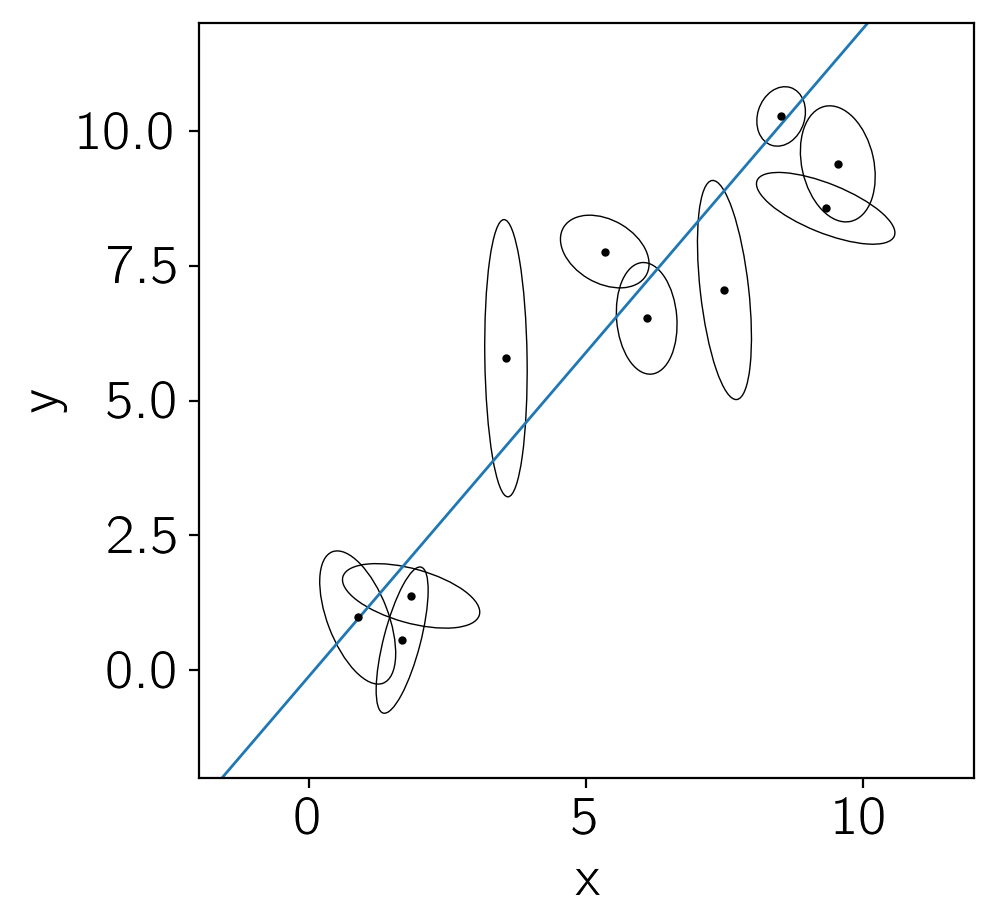

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Reproducible!
np.random.seed(42)

# A helper function to make the plots with error ellipses
def plot_error_ellipses(ax, X, S, color="k"):
    for n in range(len(X)):
        vals, vecs = np.linalg.eig(S[n])
        theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
        w, h = 2 * np.sqrt(vals)
        ell = Ellipse(xy=X[n], width=w, height=h,
                      angle=theta, color=color, lw=0.5)
        ell.set_facecolor("none")
        ax.add_artist(ell)
    ax.plot(X[:, 0], X[:, 1], ".", color=color, ms=4)

# Generate the true coordinates of the data points.
N = 10
m_true = 1.2
b_true = -0.1
X_true = np.empty((N, 2))
X_true[:, 0] = np.random.uniform(0, 10, N)
X_true[:, 1] = m_true * X_true[:, 0] + b_true
X = np.empty((N, 2))

# Generate error ellipses and add uncertainties to each point.
S = np.zeros((N, 2, 2))
for n in range(N):
    L = np.zeros((2, 2))
    L[0, 0] = np.exp(np.random.uniform(-1, 1))
    L[1, 1] = np.exp(np.random.uniform(-1, 1))
    L[1, 0] = 0.5 * np.random.randn()
    S[n] = np.dot(L, L.T)
    X[n] = np.random.multivariate_normal(X_true[n], S[n])

# Plot the simulated dataset.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x0 = np.array([-2, 12])
ax.plot(x0, m_true*x0 + b_true, lw=1)
plot_error_ellipses(ax, X, S)
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.set_xlabel("x")
ax.set_ylabel("y");

In this figure, you're seeing the simulated dataset with its error ellipses shown in black.
The true linear relation that was used to simulate the data is shown in blue.

## Naïve sampling

The simplest way to fit this line to the data is to invoke $N$ new parameters $\hat{x}_n$ giving the "true" independent coordinate of each data point.
In this case, the likelihood function is:

$$
p(\{y_n,\,x_n\}\,|\,m,\,b,\,\{\hat{x}_n,\,S_n\}) = \prod_{n=1}^N \frac{1}{2\,\pi\,\sqrt{\det S_n}}
\exp\left(-\frac{1}{2}\,{\vec{r}_n}^\mathrm{T}\,{S_n}^{-1}\,{\vec{r}_n}\right)
$$

where $m$ and $b$ are the usual slope and intercept of the line, $x_n$ and $y_n$ are the observations, $S_n$ is the uncertainty tensor of the $n$-th data point:

$$
S_n = \left(\begin{array}{cc}
    {\sigma_{x,n}}^2 & {\sigma_{xy,n}} \\
    {\sigma_{xy,n}} & {\sigma_{y,n}}^2 \\
\end{array}\right) \quad,
$$

and $\vec{r}_n$ is the residual vector:

$$
\vec{r}_n = \left( x_n - \hat{x}_n \quad y_n - m\,\hat{x}_n - b \right)^\mathrm{T} \quad.
$$

Now, let's choose some priors for $m$, $b$, and $\hat{x}_n$ and sample the posterior

$$
p(m,\,b,\,\{\hat{x}_n\}\,|\,\{y_n,\,x_n,\,S_n\}) \propto
p(\{y_n,\,x_n\}\,|\,m,\,b,\,\{\hat{x}_n,\,S_n\}) \, p(m,\,b,\,\{\hat{x}_n\}) \quad.
$$

Following [Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#Prior-on-Slope-and-Intercept), let's use the prior:

$$
p(m,\,b,\,\{\hat{x}_n\}) \propto \left(1+m^2\right)^{-3/2} \quad.
$$

Formally, this prior is improper, but it'll do the trick for today.
Here's the model in code:

In [111]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

# Pre-compute the inverses for speed.
Sinv = np.array([np.linalg.inv(Sn) for Sn in S])
def log_prob_naive(params):
    # Compute the "true" model predictions.
    m, b = params[:2]
    xhat = params[2:]
    yhat = m * xhat + b
    
    # Compute the residuals.
    r = np.array(X)
    r[:, 0] -= xhat
    r[:, 1] -= yhat
    
    # Use some numpy magic to compute the likelihood (up to a constant).
    ll = -0.5*np.einsum("n...i,nij,n...j", r, Sinv, r)
    
    return ll + log_prior(params)

Let's use [emcee](http://dan.iel.fm/emcee) to sample this density:

In [112]:
import emcee

nwalkers = 64
xhat0 = np.array(X[:, 0])
p0 = np.append([m_true, b_true], xhat0)
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))

sampler_naive = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_naive)
pos, _, _ = sampler_naive.run_mcmc(p0, 5000)
sampler_naive.reset()
sampler_naive.run_mcmc(pos, 10000)
samples_naive = sampler_naive.flatchain[:, :2]

We'll look at the integrated autocorrelation time to judge convergence:

In [113]:
tau = sampler_naive.get_autocorr_time(c=4)
nsamples = len(samples_naive)
print("{0:.0f} independent samples of m".format(nsamples / tau[0]))
print("{0:.0f} independent samples of b".format(nsamples / tau[1]))

2217 independent samples of m
3267 independent samples of b


And plot the posterior constraints on $m$ and $b$:

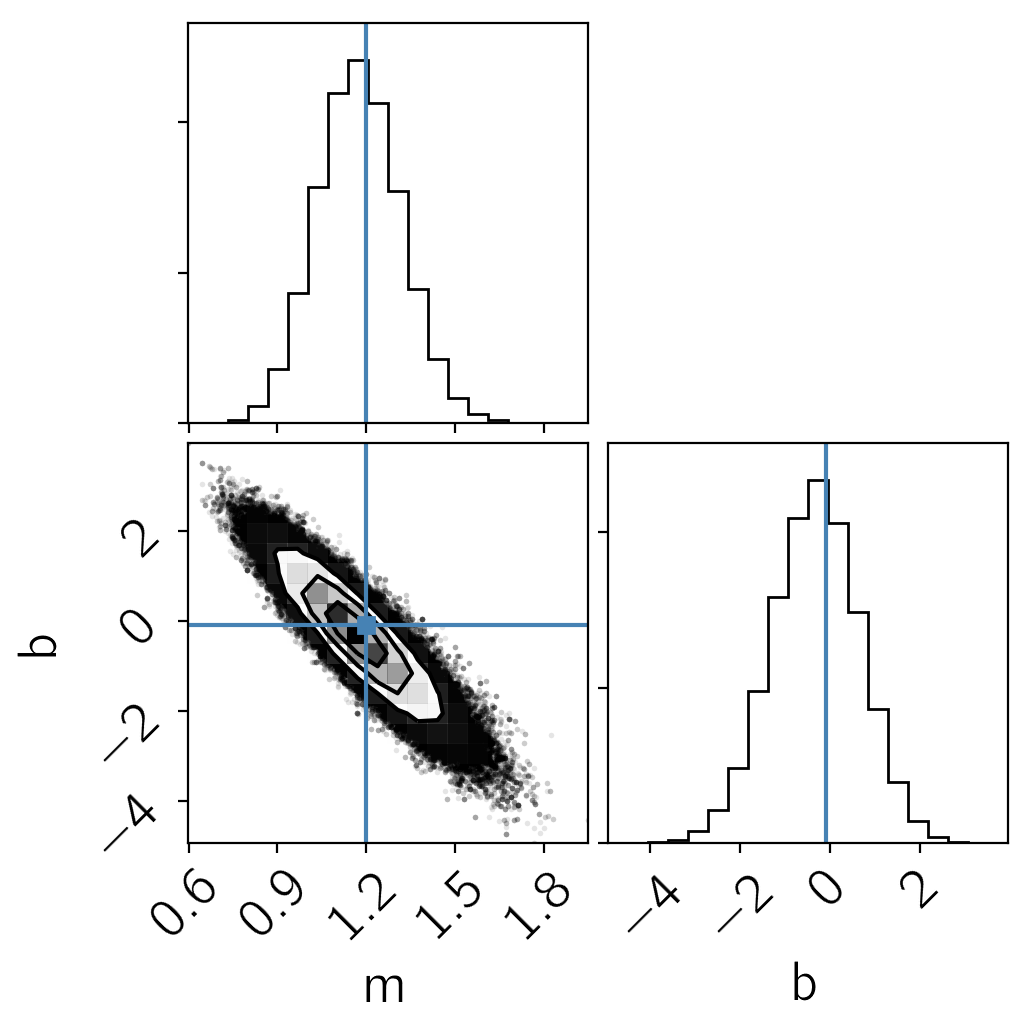

In [114]:
import corner
rng = [(x.min(), x.max()) for x in samples_naive.T]
corner.corner(samples_naive, labels=["m", "b"], truths=[m_true, b_true],
              range=rng);

Cool.
That looks fine, but the problem here is that this won't really scale well to large datasets because we'll need a parameter $\hat{x}_n$ for each data point.
It turns out (thanks to the magic of Gaussians) that we can analytically marginalize over these nuisance parameters and reduce the problem back down to 2-D.

## Marginalizing over the true coordinates

To start, let's look at a single data point $n$ and marginalize over $\hat{x}_n$ for that point.
The integral that we need to compute is:

$$
\begin{eqnarray}
p(y_n,\,x_n\,|\,m,\,b,\,S_n) &=& \int_{-x_\mathrm{min}}^{x_\mathrm{max}} p(\hat{x}_n) \, p(y_n,\,x_n\,|\,m,\,b,\,\hat{x}_n,\,S_n)\,\mathrm{d}\hat{x}_n \\
&=& \frac{1}{x_\mathrm{max} - x_\mathrm{min}} \int_{-x_\mathrm{min}}^{x_\mathrm{max}} p(y_n,\,x_n\,|\,m,\,b,\,\hat{x}_n,\,S_n)\,\mathrm{d}\hat{x}_n
\end{eqnarray}
$$

In order to simplify the math, I'll be a little sloppy here and send $x_\mathrm{min} \to -\infty$ and $x_\mathrm{max} \to \infty$, but ignore the fact that this makes the constant $1/(x_\mathrm{max} - x_\mathrm{min})$ zero.
This inconsistency is caused by the fact that we used an improper prior above and there are more rigorous ways to derive and interpret this result—by putting a broad Gaussian prior on $\hat{x}_n$, for example—but this won't change the results.
If you're willing to roll with me here (and if you aren't, too bad!) then the integral that we need to compute becomes:

$$
p(y_n,\,x_n\,|\,m,\,b,\,S_n) \propto \int_{-\infty}^{\infty}
\frac{1}{2\,\pi\,\sqrt{\det S_n}}
\exp\left(-\frac{1}{2}\,{\vec{r}_n}^\mathrm{T}\,{S_n}^{-1}\,{\vec{r}_n}\right)
\,\mathrm{d}\hat{x}_n
$$

where $r_n$ and $S_n$ are defined above.
We'll go through the pain of solving this integral in the general case below, but for now, I just tossed this into Mathematica and found:

$$
p(y_n,\,x_n\,|\,m,\,b,\,S_n) \propto \frac{1}{\sqrt{2\,\pi\,{\Sigma_n}^2}}\,
\exp\left(-\frac{{\Delta_n}^2}{2\,{\Sigma_n}^2}\right)
$$

where $\Delta_n = y_n - m\,x_n - b$ and ${\Sigma_n}^2 = (\sigma_x\,m)^2 - 2\,\sigma_{xy}\,m + {\sigma_y}^2$ or, equivalently ${\Sigma_n}^2 = \vec{v}^\mathrm{T}\,S_n\,\vec{v}$ where $\vec{v}^\mathrm{T} = (-m,\,1)$.
This likelihood function is similar to Equation (32) in [Hogg, Bovy, & Lang (2010)](https://arxiv.org/abs/1008.4686) with the added benefit that it is correct :heart:.
You can convince yourself that the version in that paper isn't quite right by checking the limiting case where $\sigma_x = 0$ and $\sigma_{xy} = 0$, and feel free to work the math to convince youself that this one is right.

Now that we've derived the marginalized likelihood function, let's use emcee to sample from the 2-D problem with the same prior $p(m,\,b)$ and confirm that we get the same results.

4402 independent samples of m
3998 independent samples of b


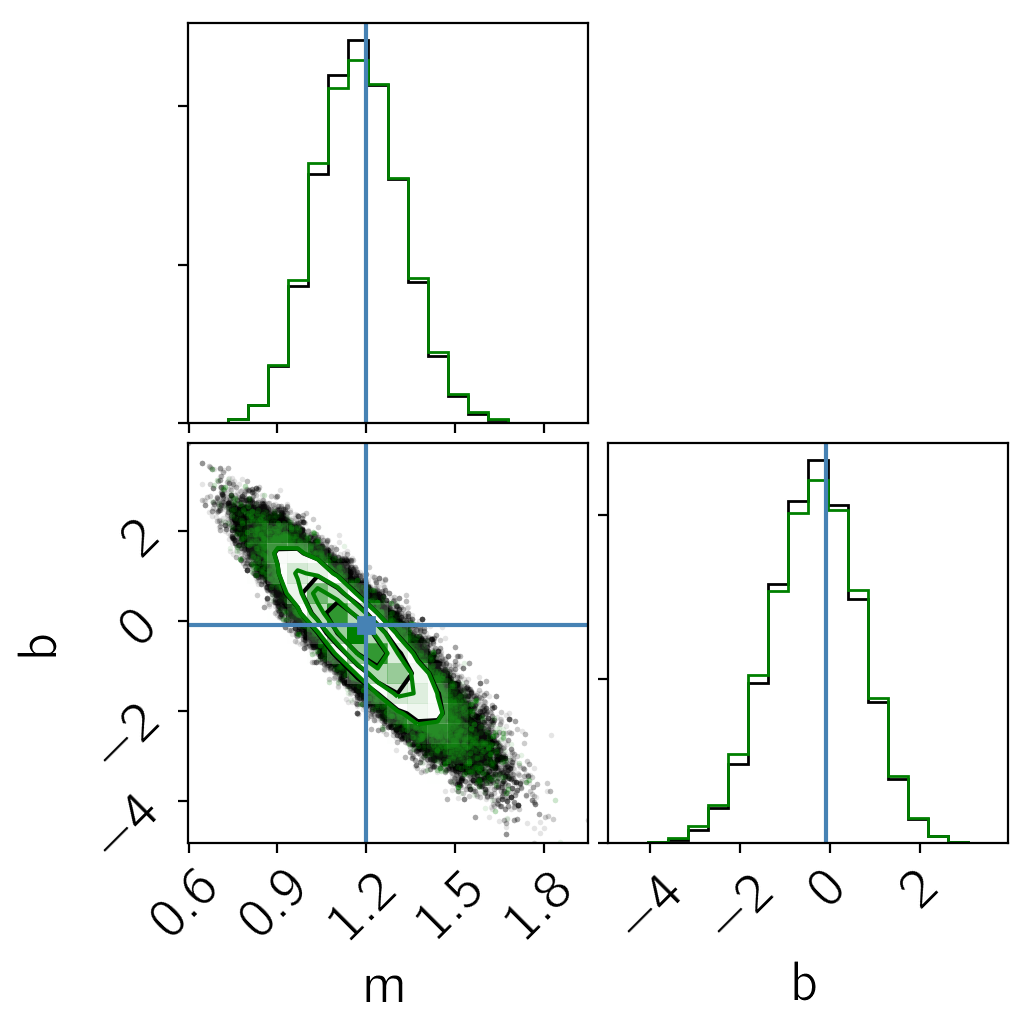

In [115]:
def log_marg_prob(params):
    m, b = params
    v = np.array([-m, 1.0])
    
    # Compute \Sigma^2 and \Delta.
    # You can probably convince yourself that this formulation of
    # \Sigma^2 is equivalent to the one in the text.
    Sigma2 = np.dot(np.dot(S, v), v)
    Delta = m * X[:, 0] + b - X[:, 1]
    
    # Compute the log likelihood up to a constant (zero, oops...).
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

# Run the MCMC with the same initialization as above.
sampler_marg = emcee.EnsembleSampler(nwalkers, 2, log_marg_prob)
pos, _, _ = sampler_marg.run_mcmc(p0[:, :2], 100)
sampler_marg.reset()
sampler_marg.run_mcmc(pos, 1000)
samples_marg = sampler_marg.flatchain

tau = sampler_marg.get_autocorr_time(c=4)
nsamples = len(samples_marg)
print("{0:.0f} independent samples of m".format(nsamples / tau[0]))
print("{0:.0f} independent samples of b".format(nsamples / tau[1]))

# Plot the posterior constraints for the naive sampling.
fig = corner.corner(samples_naive, labels=["m", "b"], truths=[m_true, b_true],
                    range=rng)

# Plot the constraints from the marginalized sampling.
# We need to re-weight the samples because we didn't need to run
# as many steps to converge in 2 dimensions as we did in 12.
w = len(samples_naive) / len(samples_marg) + np.zeros(len(samples_marg))
corner.corner(samples_marg, range=rng, color="g", fig=fig, weights=w);

In this figure, you see the same results from above (in black) that we got when we sampled in $m$, $b$, and $\hat{x}_n$.
The green results are what we got when we sampled the analytically marginalized probability density.
As expected, these results are indistinguishable within the sampling error, but the latter is more scalable and easier to sample to convergence (we evaluated the model an order of magnitude fewer times to get the same number of independent samples).

To finish this section, let's make one more plot of the results:

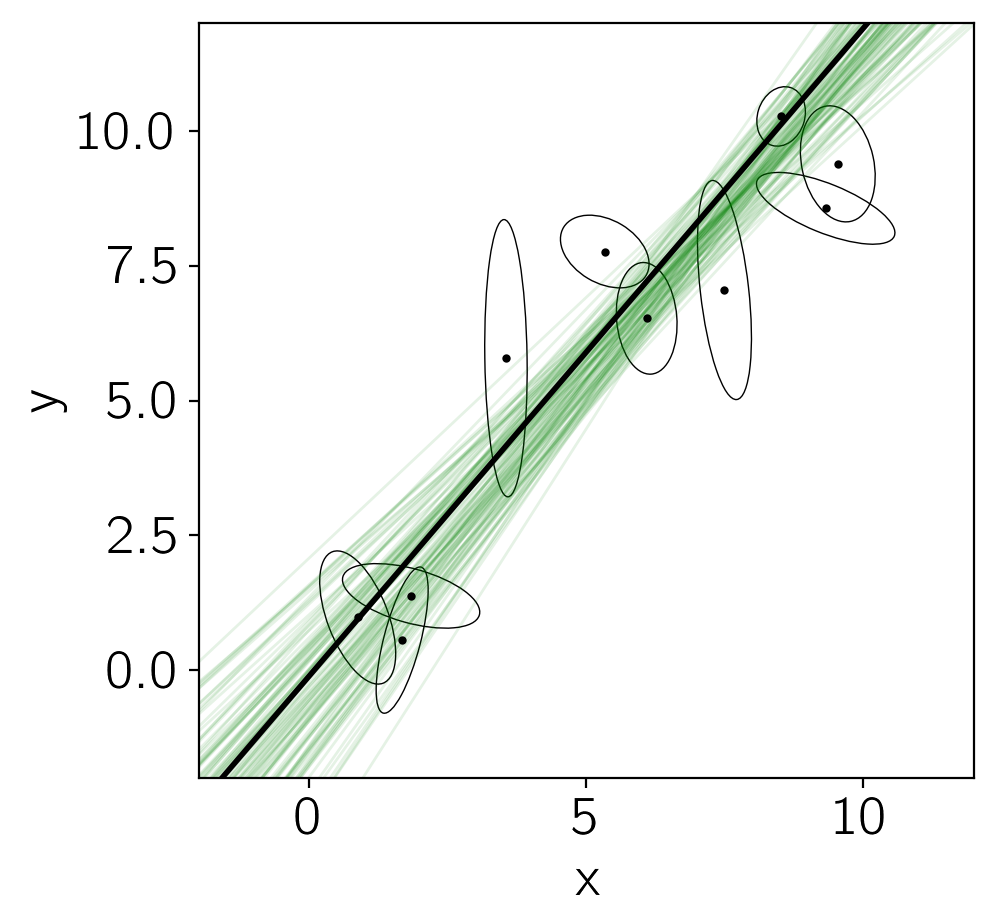

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x0 = np.array([-2, 12])

# Plot posterior predictions for a few samples.
for m, b in samples_marg[np.random.randint(len(samples_marg), size=100)]:
    ax.plot(x0, m*x0 + b, lw=1, alpha=0.1, color="g")
    
ax.plot(x0, m_true*x0 + b_true, "k", lw=2)
plot_error_ellipses(ax, X, S)
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.set_xlabel("x")
ax.set_ylabel("y");

In this figure, the true model is shown as the black line and several posterior samples are shown as light green lines.

## Intrinsic scatter

Now, let's generalize our derivation from above to include an intrinsic width in the line.
Another way of saying this is that, instead of $\hat{y}_n = m\,\hat{x}_n + b$, our model is defined by

$$
\left(\begin{array}{c}
\hat{x}_n \\ \hat{y}_n
\end{array}\right) \sim \mathcal{N}\left(
\left(\begin{array}{c}
\tilde{x}_n \\ m\,\tilde{x}_n + b
\end{array}\right),\,\Lambda
\right)
$$

where $\Lambda$ is a 2x2 tensor describing the width of the line, and we have redefined $\tilde{x}_n$ as the "true" input coordinate.
In this case, we can multiply this Gaussian by the Gaussian defined in [the first equation in the first section](#Naïve-sampling) and integrate out $\hat{x}_n$ and $\hat{y}_n$ (Section 8.1.8 of [this document](http://compbio.fmph.uniba.sk/vyuka/ml/old/2008/handouts/matrix-cookbook.pdf) might come in handy) to find:

$$
\begin{eqnarray}
&&p(\{y_n,\,x_n\}\,|\,m,\,b,\,\{\tilde{x}_n,\,S_n\},\,\Lambda) \\
&=& \prod_{n=1}^N \frac{1}{2\,\pi\,\sqrt{\det (S_n+\Lambda)}}
\exp\left(-\frac{1}{2}\,{\tilde{r}_n}^\mathrm{T}\,({S_n} + \Lambda)^{-1}\,{\tilde{r}_n}\right)
\end{eqnarray}
$$

where

$$
\tilde{r}_n = \left( x_n - \tilde{x}_n \quad y_n - m\,\tilde{x}_n - b \right)^\mathrm{T} \quad.
$$

Then we can repeat the derivation from [Section 2](#Marginalizing-over-the-true-coordinates) to find the marginalized likelihood:

$$
p(y_n,\,x_n\,|\,m,\,b,\,S_n,\,\Lambda) \propto \frac{1}{\sqrt{2\,\pi\,{\tilde{\Sigma}_n}^2}}\,
\exp\left(-\frac{{\Delta_n}^2}{2\,{\tilde{\Sigma}_n}^2}\right)
$$

where $\Delta_n$ is defined above and ${\tilde{\Sigma}_n}^2 = \vec{v}^\mathrm{T}\,(S_n + \Lambda)\,\vec{v}$.

To be more concrete, here are a few examples of the scatter that you might expect:

1. If the scatter is perpendicular to the line with some variance $\lambda^2$, then
$$
\Lambda = \frac{\lambda^2}{1+m^2}\,\left(\begin{array}{cc}
m^2 & -m \\
-m & 1
\end{array}\right)
$$
2. If the scatter is only in the $y$ direction, then
$$
\Lambda = \lambda^2\,\left(\begin{array}{cc}
0 & 0 \\
0 & 1
\end{array}\right)
$$

For simplicity, let's consider the simple case where the intrinsic scatter is in the $y$ direction.
In this case, $\vec{v}^\mathrm{T}\,\Lambda\,\vec{v}$ simplifies to $\lambda^2$.

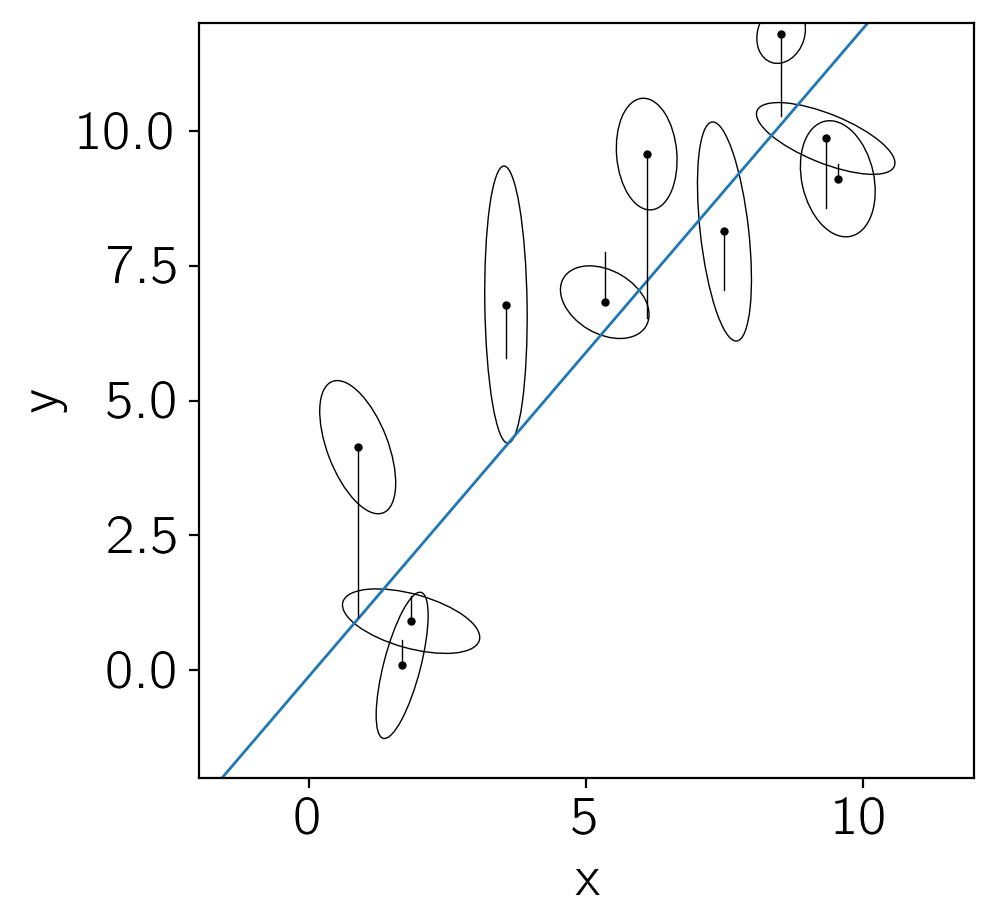

In [269]:
# Reproducible!
np.random.seed(42)

# Add some scatter perpendicular to the line.
lambda_true = 2.0
X_scatter = np.array(X)
X_scatter[:, 1] += lambda_true * np.random.randn(N)

# Plot the updated dataset.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x0 = np.array([-2, 12])
ax.plot(x0, m_true*x0 + b_true, lw=1)
plot_error_ellipses(ax, X_scatter, S)

# Plot the displacement vectors.
for n in range(N):
    ax.plot([X[n, 0], X_scatter[n, 0]],
            [X[n, 1], X_scatter[n, 1]],
            "k", lw=0.5)

ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.set_xlabel("x")
ax.set_ylabel("y");

This is the same kind of figure that we had before but now I'm indicating the extra scatter that was added to each data point with the black lines.
You can see that all of these offsets are in the $y$ direction.

To sample this model, we'll need to choose a prior on $\lambda$.
It's useful to choose a proper prior in this case so I'll choose (somewhat arbitrarily) a log-uniform prior between $e^{-5}$ and $e^5$:

$$
p(\ln\lambda) \propto \left\{\begin{array}{ll}
1 & \mathrm{if\,-5 < \ln\lambda < 5} \\
0 & \mathrm{otherwise}
\end{array}\right.
$$

7734 independent samples of m
9528 independent samples of b
5108 independent samples of lambda


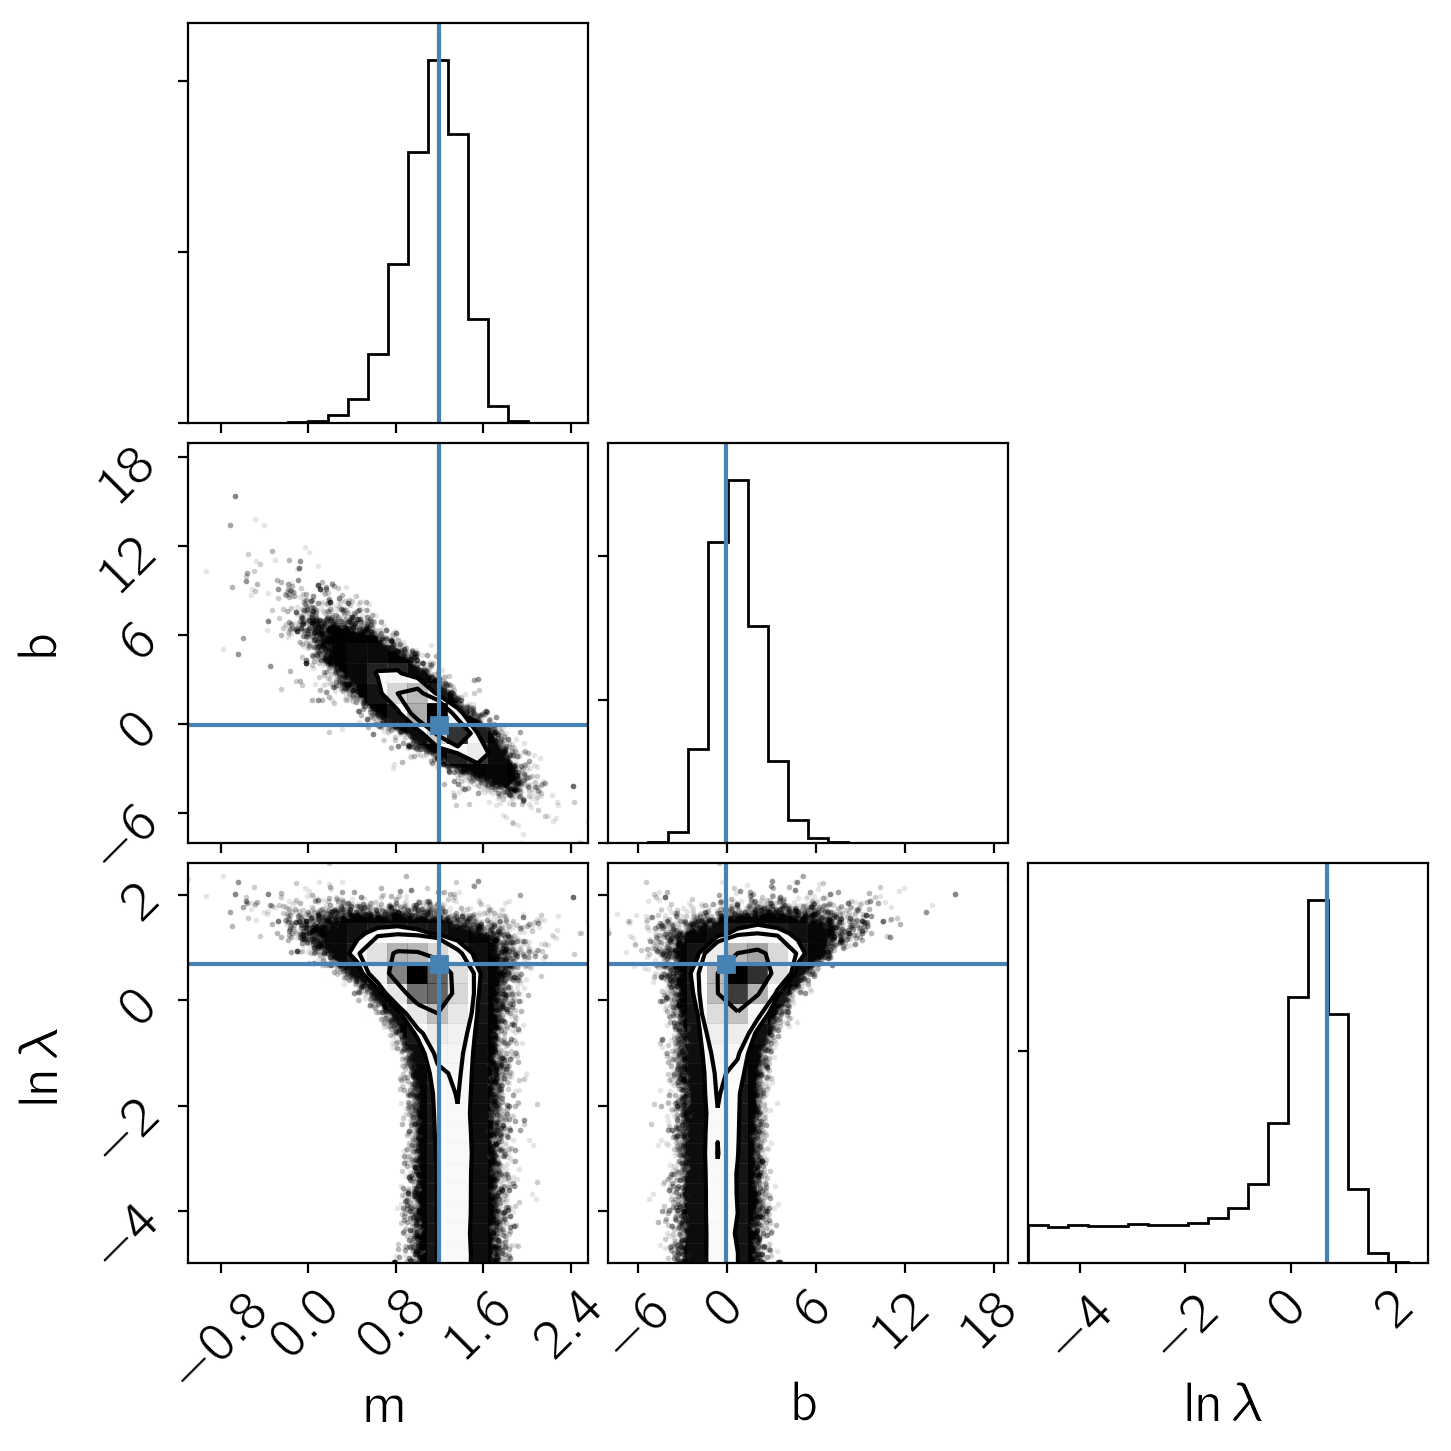

In [270]:
def log_marg_prob_scatter(params):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])
    
    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf
        
    # Compute \Sigma^2 and \Delta.
    Sigma2 = np.dot(np.dot(S, v), v) + np.exp(2*log_lambda)
    Delta = m * X_scatter[:, 0] + b - X_scatter[:, 1]
    
    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

# Run the MCMC.
sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter)
p0 = np.array([m_true, b_true, np.log(lambda_true)])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 6000)
samples_scatter = sampler_scatter.flatchain

tau = sampler_scatter.get_autocorr_time(c=4)
nsamples = len(samples_scatter)
print("{0:.0f} independent samples of m".format(nsamples / tau[0]))
print("{0:.0f} independent samples of b".format(nsamples / tau[1]))
print("{0:.0f} independent samples of lambda".format(nsamples / tau[2]))

corner.corner(samples_scatter, labels=["m", "b", "$\ln\lambda$"],
              truths=[m_true, b_true, np.log(lambda_true)]);

We can compare this sampling to the previous on (without scatter) by plotting some samples of the model in the "data" space.
You can see that the constaints are wider than previously, but things seemed to have worked well.

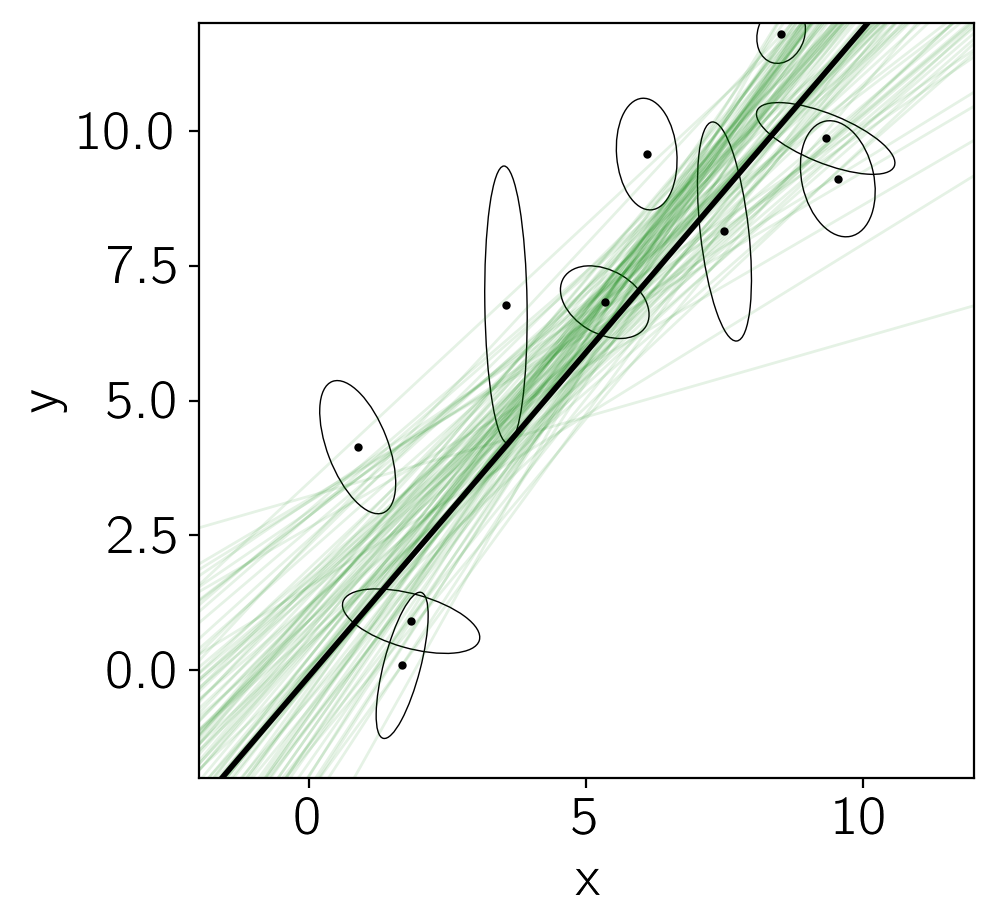

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x0 = np.array([-2, 12])

# Plot posterior predictions for a few samples.
for m, b, _ in samples_scatter[np.random.randint(len(samples_scatter), size=100)]:
    ax.plot(x0, m*x0 + b, lw=1, alpha=0.1, color="g")
    
ax.plot(x0, m_true*x0 + b_true, "k", lw=2)
plot_error_ellipses(ax, X_scatter, S)
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.set_xlabel("x")
ax.set_ylabel("y");

## Generalizing to higher dimensions

Now let's extend our discussion to fitting a plane to data in $D$ dimensions.
Some people might have just been able to intuit the correct result here, but I wanted to derive it to make sure that I was happy so here it goes...

To simplify the derivation, I'll update the notation as follows (bear with me — there's a lot going on here).
The observations are now $\{\vec{x}_n,\,y_n,\,S_n\}$ where $\vec{x}_n$ is a $D-1$ vector ${\boldsymbol{x}_n}^\mathrm{T} = (x_{1,n},\,\cdots,x_{d-1,n})$ and $S_n$ is a $D \times D$ matrix that we can write, without loss of generality, as the block matrix

$$
S_n = \left(\begin{array}{cc}
S_{x,n} & s_{xy,n} \\
s_{xy,n}^\mathrm{T} & s_{y,n}
\end{array}\right)
$$

where $S_{x,n}$ is the $D-1 \times D-1$ covariance for the $\vec{x}$s, $\vec{s}_{xy,n}$ is the $D-1$ covariance between $\vec{x}_n$ and $y_n$, and $s_{y,n} = {\sigma_{y,n}}^2$ is the (scalar) uncertainty variance for $y$.

In this space, we can rewrite the likelihood in the first equation from [Section 1](#Naïve-sampling) as

$$\begin{eqnarray}
&&p(\{y_n,\,\vec{x}_n\}\,|\,\vec{m},\,b,\,\{\boldsymbol{\hat{x}}_n,\,S_n\}) \\
&=& \prod_{n=1}^N \frac{1}{(2\,\pi)^{D/2}\,\sqrt{\det S_n}}
\exp\left(-\frac{1}{2}\,{(\vec{z}_n-M\,\boldsymbol{\hat{x}}_n-\vec{b})}^\mathrm{T}\,{S_n}^{-1}\,{(\vec{z}_n-M\,\boldsymbol{\hat{x}}_n-\vec{b})}\right)
\end{eqnarray}
$$

where ${\vec{z}_n}^\mathrm{T} = (x_{1,n},\,\ldots,\,x_{D-1,n},\,y_n)$, ${\boldsymbol{\hat{x}}_n}^\mathrm{T} = (\hat{x}_{1,n},\,\ldots,\,\hat{x}_{D-1,n},\,0)$, ${\vec{b}}^\mathrm{T} = (0,\,\ldots,\,b)$, and $M$ is the $D \times D$ matrix

$$
M = \left(\begin{array}{cc}
I_{D-1} & -\vec{m} \\
\vec{m}^\mathrm{T} & 1
\end{array}\right)
$$

where $I_{D-1}$ is the $D-1$ dimensional identity and $\vec{m}^\mathrm{T} = (m_1,\,\ldots,\,m_{D-1})$.

Now that we have that notation out of the way, we now want to complete the square and marginalize over $\boldsymbol{\hat{x}}_n$.
Thanks to the magic of Gaussians (see [Appendix A of R&W](http://www.gaussianprocess.org/gpml/), for example), this integral can be done easily if we can rewrite the likelihood as a $D$ dimensional Gaussian for $\boldsymbol{\hat{x}}_n$.
Then the marginalized likelihood will be a one dimensional Gaussian with mean given by the last element of the mean vector and variance given by the bottom left entry in the covariance matrix.
To manipulate this equation, let's write the argument of the exponential as follows

$$
\begin{eqnarray}
&& {(z_n-M\,\hat{x}_n-\vec{b})}^\mathrm{T}\,{S_n}^{-1}\,(\vec{z}_n-M\,\boldsymbol{\hat{x}}_n-\vec{b})\\
&=& {\left[M\,M^{-1}\,(\vec{z}_n-M\,\boldsymbol{\hat{x}}_n-\vec{b})\right]}^\mathrm{T}\,{S_n}^{-1}\,\left[M\,M^{-1}\,(z_n-M\,\hat{x}_n-\vec{b})\right]\\
&=& {\left[M^{-1}\,(\vec{z}_n - \vec{b}) - \boldsymbol{\hat{x}}_n\right]}^\mathrm{T}\,M^\mathrm{T}\,{S_n}^{-1}\,M\,\left[M^{-1}\,(\vec{z}_n - \vec{b}) - \boldsymbol{\hat{x}}_n\right]
\end{eqnarray}
$$

to find that each term in the likelihood is a $D$ dimensional Gaussian for $\boldsymbol{\hat{x}}_n$ with mean

$$
\mu_n = M^{-1}\,(\vec{z}_n - \vec{b})
$$

and covariance

$$
C_n = M^{-1}\,S_n\,(M^{-1})^\mathrm{T} \quad.
$$

Using [the block matrix inverse equations](https://en.wikipedia.org/wiki/Block_matrix#Block_matrix_inversion), we can  find the inverse of $M$ to be

$$
M^{-1} = \frac{1}{1+\vec{m}^\mathrm{T}\,\vec{m}}\left(\begin{array}{cc}
I_{D-1} - \vec{m}^\mathrm{T}\,\vec{m} & \vec{m} \\
-\vec{m}^\mathrm{T} & 1
\end{array}\right) \quad.
$$

Armed with these equations and some patience, we can derive the general expressions for the mean $\mu$ and covariance $C$, but I'll spare you the details and just give the results for the relevant values.
After marginalizing over $\hat{x}_n$, the marginalized likelihood resembles the previous one

$$
p(y_n,\,\vec{x}_n\,|\,\vec{m},\,b,\,S_n) \propto \frac{1}{\sqrt{2\,\pi\,{\Sigma_{D,n}}^2}}\,
\exp\left(-\frac{{\Delta_{D,n}}^2}{2\,{\Sigma_{D,n}}^2}\right)
$$

where

$$
\Delta_{D,n} = y_n - \vec{m}^\mathrm{T}\,\vec{x}_n - b
$$

and

$$
{\Sigma_{D,n}}^2 = \vec{m}^\mathrm{T}\,S_{x,n}\,\vec{m} - 2\,\vec{m}^\mathrm{T}\,\vec{s}_{xy,n} + s_y \quad.
$$

Finally, we can include intrinsic scatter as above by replacing $S_n$ by $S_n + \Lambda$.
For example, if you want to model intrinsic scatter in the $D$-th dimension, you would update

$$
{\Sigma_{D,n}}^2 = \vec{m}^\mathrm{T}\,S_{x,n}\,\vec{m} - 2\,\vec{m}^\mathrm{T}\,\vec{s}_{xy,n} + s_y + \lambda^2
$$

and also fit for $\lambda$.